In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from PIL import Image
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from zipfile import ZipFile
import os
from os import path
import shutil


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
url = '/content/drive/MyDrive/CSE4238/'

## Dataset Proprosecing

In [ ]:
dataset_C = url + 'Dataset C.zip'
with ZipFile(dataset_C, 'r') as zip:
  zip.extractall()

In [ ]:
df = pd.read_csv('/content/training-c.csv',delimiter=None)
dfnew = df.drop(['original filename','scanid','database name original','contributing team','database name'],axis=1)
print(dfnew.shape)
dfnew.head()

(24298, 2)


,filename,digit
0,c00000.png,6
1,c00001.png,1
2,c00002.png,3
3,c00003.png,2
4,c00004.png,7


In [ ]:
TRAIN_PATH = url + 'Train dataset'
os.mkdir(TRAIN_PATH)

In [ ]:
PATH = '/content/'
def processImages(folder_name):
  src = PATH + folder_name + '/'
  dir_folders = os.listdir(src)
  for dir_name in dir_folders:
    file_name = os.path.join(src, dir_name)
    if os.path.isfile(file_name):
      shutil.copy(file_name, TRAIN_PATH) 

processImages('training-c')

In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(dfnew, TRAIN_PATH, train_transform)
test_data = Dataset(dfnew, TRAIN_PATH, test_transform)

print("Trainig Samples: ", len(train_data))
print("Trainig Samples: ", len(test_data))

Trainig Samples:  24298
Trainig Samples:  24298


## 1st HyperParam

In [ ]:
batch_size = 120
num_iters = 20000
input_dim = 28*28
num_hidden = 200
output_dim = 10

learning_rate = 0.05

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


test_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))



class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()
 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()
 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()
 
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        self.relu_5= nn.ReLU()
 
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.relu_6 = nn.ReLU()
 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        out  = self.linear_5(out)
        out = self.relu_5(out)
 
        out  = self.linear_6(out)
        out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas

model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)



criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

98
Train dataloader:162
Test dataloader:41
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Iteration: 500. Loss: 2.3026745319366455. Accuracy: 9.981477670302532
Epoch:  5
Epoch:  6
Epoch:  7
Iteration: 1000. Loss: 2.30147385597229. Accuracy: 9.693352541675242
Epoch:  8
Epoch:  9
Epoch:  10
Iteration: 1500. Loss: 2.30252742767334. Accuracy: 9.693352541675242
Epoch:  11
Epoch:  12
Epoch:  13
Iteration: 2000. Loss: 2.302635431289673. Accuracy: 9.693352541675242
Epoch:  14
Epoch:  15
Epoch:  16
Iteration: 2500. Loss: 2.303741455078125. Accuracy: 9.796254373327844
Epoch:  17
Epoch:  18
Epoch:  19
Iteration: 3000. Loss: 2.301081418991089. Accuracy: 10.043218769294093
Epoch:  20
Epoch:  21
Epoch:  22
Iteration: 3500. Loss: 2.3005096912384033. Accuracy: 9.796254373327844
Epoch:  23
Epoch:  24
Epoch:  25
Iteration: 4000. Loss: 2.3009772300720215. Accuracy: 11.278040749125335
Epoch:  26
Epoch:  27
Epoch:  28
Iteration: 4500. Loss: 2.3003342151641846. Accuracy: 9.693352541675242
Epoch:  29
Epoch:  30
Epo

[2.3026745319366455, 2.30147385597229, 2.30252742767334, 2.302635431289673, 2.303741455078125, 2.301081418991089, 2.3005096912384033, 2.3009772300720215, 2.3003342151641846, 2.2991459369659424, 2.2611732482910156, 2.2950780391693115, 2.228545665740967, 2.230820894241333, 2.1961758136749268, 2.148905038833618, 2.121037721633911, 2.0067851543426514, 1.978904128074646, 1.9603664875030518, 2.056060791015625, 1.846671462059021, 1.8018015623092651, 1.8290098905563354, 1.8442813158035278, 2.035761594772339, 1.9871656894683838, 1.8520572185516357, 1.9800063371658325, 1.8737784624099731, 1.7186791896820068]


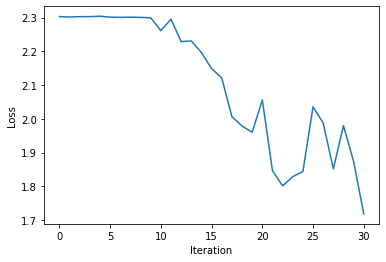

In [ ]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/CSE4238/model_base.pkl')

[2.310093879699707, 2.3064181804656982, 2.3324429988861084, 2.322636604309082, 2.288396120071411, 2.2959084510803223, 2.26566219329834, 2.289353132247925, 2.306072950363159, 2.3220744132995605, 2.3413946628570557, 2.3311867713928223, 2.3708462715148926, 2.31805157661438, 2.3308818340301514, 2.3625757694244385, 2.31941294670105, 2.3873612880706787, 2.229706048965454, 2.3084824085235596, 2.334162473678589, 2.310136556625366, 2.3164284229278564, 2.3479793071746826, 2.2620348930358887, 2.3112552165985107, 2.3748362064361572, 2.313717842102051, 2.335014820098877, 2.3064353466033936, 2.330256700515747]


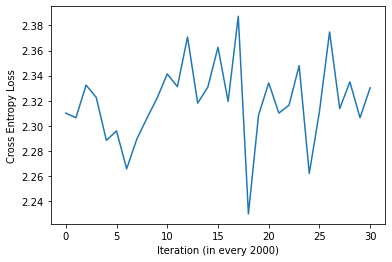

In [ ]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 2000)')
plt.show()

## 2nd HyperParam

In [ ]:
batch_size = 200
num_iters = 20000
input_dim = 28*28
num_hidden = 400
output_dim = 10

learning_rate = 0.05

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


test_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))



class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()
 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.Softmax(dim=0)
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()
 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()
 
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        self.relu_5= nn.ReLU()
 
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.relu_6 = nn.ReLU()
 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        out  = self.linear_5(out)
        out = self.relu_5(out)
 
        out  = self.linear_6(out)
        out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas

model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)



criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

164
Train dataloader:98
Test dataloader:25
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Iteration: 500. Loss: 2.303546190261841. Accuracy: 10.043218769294093
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Iteration: 1000. Loss: 2.300708532333374. Accuracy: 9.508129244700555
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Iteration: 1500. Loss: 2.3020665645599365. Accuracy: 13.932908005762503
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Iteration: 2000. Loss: 2.263448715209961. Accuracy: 15.023667421280098
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Iteration: 2500. Loss: 2.254420518875122. Accuracy: 11.75138917472731
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Iteration: 3000. Loss: 2.2260096073150635. Accuracy: 17.12286478699321
Epoch:  32
Epoch:  33
Epoch:  34
Epoch:  35
Epoch:  36
Iteration: 3500. Loss: 2.1909728050231934. Accuracy: 18.275365301502365
Epoch:  37
Epoch:  38
Epoch:  39
Epoch:  40
Epoch:  41
Iteration: 4000. Lo

[2.303546190261841, 2.300708532333374, 2.3020665645599365, 2.263448715209961, 2.254420518875122, 2.2260096073150635, 2.1909728050231934, 2.1177306175231934, 2.1820931434631348, 2.2766475677490234, 2.375851631164551, 2.120600461959839, 2.0579473972320557, 2.1991324424743652, 2.0000104904174805, 1.9491196870803833, 2.211587429046631, 1.993056297302246, 1.9665577411651611, 1.8110647201538086, 1.7870597839355469, 1.7405704259872437, 1.6358720064163208, 1.631320595741272, 1.6327944993972778, 1.5102561712265015, 1.4114570617675781, 1.4771047830581665, 1.426733374595642, 1.4797805547714233, 1.1620373725891113, 1.2035722732543945]


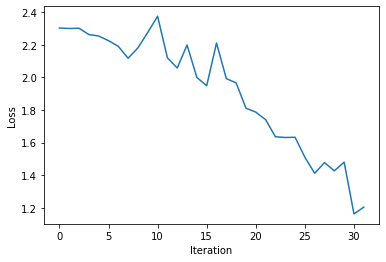

In [ ]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

## 3rd HyperParam

In [ ]:
batch_size = 250
num_iters = 20000
input_dim = 28*28
num_hidden = 200
output_dim = 10

learning_rate = 0.05

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

205


In [ ]:
test_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:78
Test dataloader:20


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()
 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()


 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)


 
        
        probas  = self.linear_out(out)
        return probas

model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)



criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Iteration: 500. Loss: 2.2943902015686035. Accuracy: 14.75612265898333
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Iteration: 1000. Loss: 2.2646305561065674. Accuracy: 19.59250874665569
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Iteration: 1500. Loss: 2.226820945739746. Accuracy: 23.23523358715785
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Iteration: 2000. Loss: 2.0628232955932617. Accuracy: 25.375591685532
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Epoch:  32
Epoch:  33
Iteration: 2500. Loss: 2.100090503692627. Accuracy: 35.80983741510599
Epoch:  34
Epoch:  35
Epoch:  36
Epoch:  37
Epoch:  38
Epoch:  39
Iteration: 3000. Loss: 1.9060630798339844. Accuracy: 23.605680181107225
Epoch:  40
Epoch:  41
Epoch:  42
Epoch:  43
Epoch:  44
Epoch:  45
Iteration: 3500. Loss: 2.081979751586914. Accuracy: 29.16237909034781
Epoch:  46
Epoch:  47


[2.2943902015686035, 2.2646305561065674, 2.226820945739746, 2.0628232955932617, 2.100090503692627, 1.9060630798339844, 2.081979751586914, 1.8771225214004517, 1.7560514211654663, 1.7210677862167358, 1.5689659118652344, 2.0176637172698975, 1.6277436017990112, 1.5926481485366821, 1.5009082555770874, 1.5070253610610962, 1.3537652492523193, 1.2996548414230347, 1.2161743640899658, 1.2330842018127441, 1.2811919450759888, 1.2824664115905762, 1.041042447090149, 1.1293370723724365, 1.412211537361145, 1.0577017068862915, 1.2583272457122803, 1.0386857986450195, 0.7466628551483154, 0.7459991574287415, 1.2185770273208618]


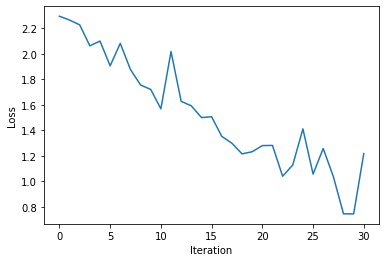

In [ ]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

## 4th HyperParam

In [ ]:
batch_size = 150
num_iters = 20000
input_dim = 28*28
num_hidden = 220
output_dim = 10

learning_rate = 0.01

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


123


In [ ]:
test_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:130
Test dataloader:33


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()

        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.softmax1 = nn.Softmax(dim=0)
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()

        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()

        

 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)

        out  = self.linear_2(out)
        out = self.softmax1(out)
        
        out  = self.linear_3(out)
        out = self.relu_2(out)
 
        out  = self.linear_4(out)
        out = self.relu_3(out)

        
 
        
        probas  = self.linear_out(out)
        return probas


In [ ]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=215, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=215, out_features=215, bias=True)
  (softmax1): Softmax(dim=0)
  (linear_3): Linear(in_features=215, out_features=215, bias=True)
  (relu_2): ReLU()
  (linear_4): Linear(in_features=215, out_features=215, bias=True)
  (relu_3): ReLU()
  (linear_out): Linear(in_features=215, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Iteration: 500. Loss: 0.9222198724746704. Accuracy: 66.76270837620909
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Iteration: 1000. Loss: 0.49434950947761536. Accuracy: 74.56266721547644
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Iteration: 1500. Loss: 0.4592575132846832. Accuracy: 76.18851615558756
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Iteration: 2000. Loss: 0.4194580018520355. Accuracy: 77.73204363037662
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Iteration: 2500. Loss: 0.3163191080093384. Accuracy: 78.37003498662276
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Iteration: 3000. Loss: 0.4061509072780609. Accuracy: 78.53467791726693
Epoch:  25
Epoch:  26
Epoch:  27
Iteration: 3500. Loss: 0.34356310963630676. Accuracy: 79.81066062975921
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Iteration: 4000. Loss: 0.3987056314945221. Accuracy: 78.96686561020786
Epoch:  32
Epoch:  33
Epoch:  34
Epoch:  35
Iteration: 4500. Loss: 0.42568162083625793. Accuracy: 7

[0.9222198724746704, 0.49434950947761536, 0.4592575132846832, 0.4194580018520355, 0.3163191080093384, 0.4061509072780609, 0.34356310963630676, 0.3987056314945221, 0.42568162083625793, 0.24554143846035004, 0.4424302279949188, 0.2783125340938568, 0.2897300720214844, 0.36422696709632874, 0.22078925371170044, 0.23068352043628693, 0.15674205124378204, 0.4076344668865204, 0.2892744839191437, 0.2735910415649414, 0.15909062325954437, 0.1752205491065979, 0.2744414210319519, 0.17723530530929565, 0.20472587645053864, 0.4568621516227722, 0.17829598486423492, 0.3903292119503021, 0.17409604787826538, 0.2439488023519516, 0.28138530254364014]


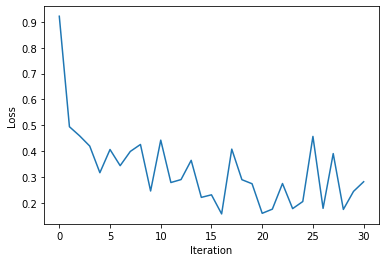

In [ ]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

## 5th param

In [ ]:
batch_size = 150
num_iters = 28000
input_dim = 28*28
num_hidden = 220
output_dim = 10

learning_rate = 0.005

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


172


In [ ]:
test_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:130
Test dataloader:33


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()

        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.softmax1 = nn.Softmax(dim=0)
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()

        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()

        

 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)

        out  = self.linear_2(out)
        out = self.softmax1(out)
        
        out  = self.linear_3(out)
        out = self.relu_2(out)
 
        out  = self.linear_4(out)
        out = self.relu_3(out)

        
 
        
        probas  = self.linear_out(out)
        return probas


In [ ]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=220, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=220, out_features=220, bias=True)
  (softmax1): Softmax(dim=0)
  (linear_3): Linear(in_features=220, out_features=220, bias=True)
  (relu_2): ReLU()
  (linear_4): Linear(in_features=220, out_features=220, bias=True)
  (relu_3): ReLU()
  (linear_out): Linear(in_features=220, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Iteration: 500. Loss: 1.086963415145874. Accuracy: 59.04507100226384
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Iteration: 1000. Loss: 0.4986721873283386. Accuracy: 74.56266721547644
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Iteration: 1500. Loss: 0.5199794769287109. Accuracy: 77.85552582835975
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Iteration: 2000. Loss: 0.33926627039909363. Accuracy: 78.14365095698703
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Iteration: 2500. Loss: 0.2947145700454712. Accuracy: 79.66659806544557
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Iteration: 3000. Loss: 0.26443085074424744. Accuracy: 80.55155381765796
Epoch:  25
Epoch:  26
Epoch:  27
Iteration: 3500. Loss: 0.2722240686416626. Accuracy: 81.08664334225149
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Iteration: 4000. Loss: 0.19036433100700378. Accuracy: 80.63387528298004
Epoch:  32
Epoch:  33
Epoch:  34
Epoch:  35
Iteration: 4500. Loss: 0.21240048110485077. Accuracy: 8

[1.086963415145874, 0.4986721873283386, 0.5199794769287109, 0.33926627039909363, 0.2947145700454712, 0.26443085074424744, 0.2722240686416626, 0.19036433100700378, 0.21240048110485077, 0.112788125872612, 0.1748569905757904, 0.1623501181602478, 0.2924354076385498, 0.06141529232263565, 0.106606125831604, 0.08748757094144821, 0.08781550824642181, 0.07287487387657166, 0.07211235910654068, 0.18900690972805023, 0.14573724567890167, 0.0794447809457779, 0.07559312880039215, 0.06842584908008575, 0.12433741241693497, 0.13746583461761475, 0.08532184362411499, 0.05441800504922867, 0.04727332293987274, 0.028376543894410133, 0.11393707245588303, 0.07067891955375671, 0.0379897765815258, 0.05539216473698616, 0.053930480033159256, 0.043109599500894547, 0.059391118586063385, 0.09493108838796616, 0.16223588585853577, 0.1776944249868393, 0.025147106498479843, 0.09092492610216141, 0.049198273569345474, 0.052364204078912735]


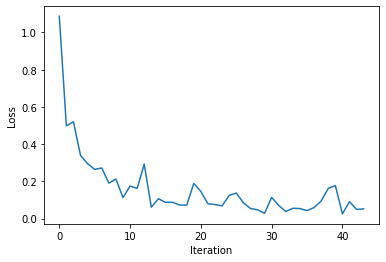

In [ ]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

## Save and load Model

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/CSE4238/model_base3.pkl')

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/CSE4238/model_base.pkl'))